# Rapport Groupe Thématique de Travail

## Discrétisation du problème $ -\Delta u = f$ 

On s'intéresse à la discrétisation du problème suivante : 

$$ -\Delta u = f$$ 

sur l'intervalle $ \Omega = [0,1]\times [0,1]$ où $u = 0$ sur $ \partial \Omega$. 

La fonction $f$ est définie de la manière suivante : 

$$ f(x_1,x_2) = 6(1-3x_1+2x_1^2)(x_2-1)^3x_2 + 6(1-3x_2+2x_2^2)(x_1-1)^3x_1$$. 

On connait l'expression de u qui est la suivante : 

$$ u(x_1,x_2) = x_1x_2(x_1-1)^3(x_2-1)^3$$

Le but de ce rapport est de retrouver $u$ par différences finies. Pour cela nous écrirons une fonction qui retournera la matrice de discrétisation du Laplacien, nous résolverons ensuite le système et comparerons la solution approchée à celle exacte connue.

On commence par importer les packages dont nous avons besoin.

In [81]:
import numpy as np
import scipy.sparse as sparse   # Algèbre linéaire creuse
import matplotlib.pyplot as plt # Pour les graphiques
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import Axes3D

La fonction suivante permet d'écrire la matrice de la discrétisation du laplacien dans notre cas. On découpe l'intervalle $[0,1]\times[0,1]$ en $N$ intervalles en $x$ et en $y$. Elle retourne une matrice de taille $(N+1)\times(N+1)$.

In [82]:
def matrix_lap(N):
    """Retourne une matrice qui discrétise le laplacien de u dans le domaine Omega = [0,1]x[0,1], 
    découpé en N intervalles en x et y. La matrice finale est une matrice scipy.sparse CSR matrix. 
    Cette matrice est de taille (N+1)*(N+1)"""

    h = 1./N
    h2 = h*h

    #On note les inconnues de 0 à Nx suivant x et 0 à Ny suivant y. La taille du problème est donc (Nx+1)*(Ny+1).

    #Cela correspond à x_i = i*h et y_j = j*h et la numérotation (i,j) --> k := (N+1)*j+i.

    taille = (1+N)*(1+N)

    diags = np.zeros((5,taille))

    #Diagonale principale
    diags[2,:] = 1.
    diags[2, N+2:taille - (N+2)] = -4./h2
    diags[2, np.arange(2*N+1, taille, N+1)] = 1.
    diags[2, np.arange(2*N+2, taille, N+1)] = 1.
              
    #Diagonale "-1"
    diags[1,N+1:taille-(N+1)] = 1./h2
    diags[1, np.arange(2*N, taille, N+1)] = 0.
    diags[1, np.arange(2*N+1, taille, N+1)] = 0.
    
    #Diagonale "+1"
    diags[3, N+3:taille-(N+1)] = 1./h2
    diags[3, np.arange(2*N+2, taille, N+1)] = 0.
    diags[3, np.arange(2*N+3, taille, N+1)] = 0.

    #Diagonale "-(N+1)"
    diags[0, 1 : taille - (2*N+3)] = 1./h2
    diags[0, np.arange(N,taille,N+1)] = 0.
    diags[0, np.arange(N+1,taille,N+1)] = 0.

    #Diagonale "+(N+1)"
    diags[4, taille - N*N + 2 : taille - 1] = 1./h2
    diags[4, np.arange(taille - N*N + 1 + N ,taille,N+1)] = 0.
    diags[4, np.arange(taille - N*N + 2 + N ,taille,N+1)] = 0.

    #Construction de la matrice creuse
    A = sparse.spdiags(diags,[-(N+1),-1,0,1,(N+1)],taille,taille, format = "csr")

    return A

Munis de cette fonction, il ne nous reste plus qu'à résoudre le problème en suivante l'ordre de numérotation des sommets qui est le suivant : $k = i + (N+1)\times j, \quad i = 0,\ldots,N, \quad j = 0,\ldots,N$

Voyons ce que nous retourne la fonction matrix_lap pour N = 2 et N = 3.

In [83]:
print(matrix_lap(2).todense())

[[  1.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   1.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   1.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   1.   0.   0.   0.   0.   0.]
 [  0.   4.   0.   4. -16.   4.   0.   4.   0.]
 [  0.   0.   0.   0.   0.   1.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   1.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.]]


In [84]:
print(matrix_lap(3).todense())

[[  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   9.   0.   0.   9. -36.   9.   0.   0.   9.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   9.   0.   0.   9. -36.   9.   0.   0.   9.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   9.   0.   0.   9. -36.   9.   0.   0.   9.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   9.   0.   0.   9. -36.   9.   0.   0.
    9.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0

Par suite, nous écrivons le code pour la fonction $f$ et notre solution exacte $u$

In [85]:
def f(x1,x2):
    return 6.*(1.-3.*x1+2.*x1**2)*((x2-1.)**3)*x2 + 6.*(1.-3.*x2+2.*x2**2)*((x1-1.)**3)*x1

def u(x1,x2):
    return x1*x2*((x1-1.)**3)*((x2-1))**3

On va résoudre le problème pour N = 100. On initialise le maillage en $x$ et $y$ comme suit :

In [86]:
N = 100

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)

On écrit la fonction qui sort la solution approchée du problème.

In [87]:
def sol_disc(N):
    
    F = np.zeros((N+1)*(N+1))   #Allocation mémoire de f

    for i in np.arange(1,N):    #(1,N) car on veut que ce soit 0 sur les bords
        for j in np.arange(1,N):
            k = i + j*(N+1)
            F[k] = f(x[i],y[j])

    U = np.zeros((N+1)*(N+1))   #matrice pour la solution
    A = matrix_lap(N)
        
    U = spsolve(A,F)
    
    return U


Et on affiche finalement la solution 

Text(0.5, 0.92, 'Solution discrétisée')

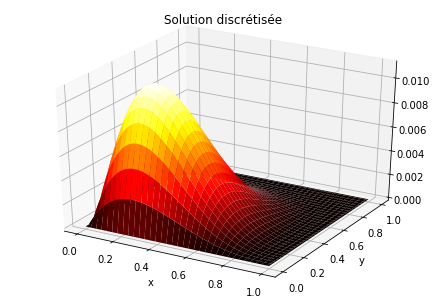

In [88]:
U = sol_disc(N)
fig = plt.figure(1)
ax = Axes3D(fig)
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y, U.reshape((N+1,N+1)), cmap='hot')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Solution discrétisée")

On va la comparer avec le graphique de la solution exacte par la fonction suivante : 

Text(0.5, 0.92, 'Solution exacte')

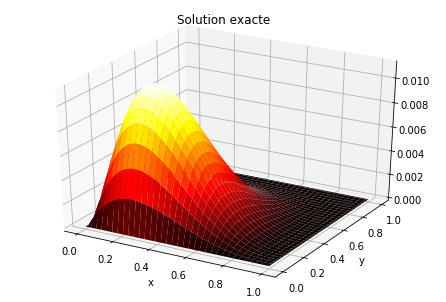

In [89]:
def sol_exacte(N):
    V = np.zeros((N+1)*(N+1))   #Allocation mémoire sol exacte
    
    for i in np.arange(N+1):
        for j in np.arange(N+1):
            k = i + j*(N+1)
            V[k] = u(x[i],y[j])
    
    return V

V = sol_exacte(N)

fig2 = plt.figure(2)
ax = Axes3D(fig2)
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,V.reshape((N+1,N+1)),cmap = 'hot')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Solution exacte")

On peut remarquer que les graphes sont très ressemblants, ce qui est une bonne nouvelle. Cependant, nous allons calculer l'erreur entre la solution approchée et exacte afin de vérifier la justesse de notre discrétisation.

In [90]:
def erreur_du_cours(A,E,N):
    return np.sum((E-A)**2)/((N+1)**2)

err1 = erreur_du_cours(U,V,N)
print("{:8s} {:12s}".
    format("Taille", "Erreur demandée"))
print("{:8d} {:12.5e}".
    format((N+1)*(N+1), err1))

Taille   Erreur demandée
   10201  9.12832e-13


In [91]:
def erreur_abs(A,E,N):
    return np.max(np.abs(E - A))

err2 = erreur_abs(U,V,N)
print("{:8s} {:12s}".
    format("Taille", "Erreur absolue"))
print("{:8d} {:12.5e}".
    format((N+1)*(N+1), err2))

Taille   Erreur absolue
   10201  1.85769e-06


Lorsque l'on augmente la valeur de $N$, on remarque que les erreurs diminuent fortement. On peut donc en conclure que notre discrétisation est cohérente.

## Interpolation du problème par des fonctions polynômiales

Dans cette partie, nous cherchons à changer la valeur de la solution sur les bords. On s'intéresse à la discrétisation du problème suivante sur un domaine $\Omega = [0,1] \times [0,1]$ : $$ -\Delta u = 0 $$

Avec $u$ valant $x(x-\frac{1}{2})\alpha$ sur la première moitié du bord bas (c'est à dire pour $x \leq 0.5$) puis $0$ et $u$ valant $0$ sur la première moitié du bord haut et après $(x-1)(x-\frac{1}{2})\beta$. L'interpolation dépend donc également de deux paramètres réels $\alpha$ et $\beta$.


On commence par importer les différents modules et définir les fonctions pour le bord haut et le bord bas.

In [92]:
import numpy as np
import scipy.sparse as sparse   # Algèbre linéaire creuse
import matplotlib.pyplot as plt # Pour les graphiques
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import Axes3D

In [93]:
def fb(x,y,alpha):
    return x*(x-(1./2.))*alpha

def fh(x,y,beta):
    return (x-1.)*(x-(1./2.))*beta

Et on discrétise le problème de la façon suivante : 

In [94]:
def sol_disc_inter(N, alpha, beta):
    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)

    F = np.zeros((N+1)*(N+1))      #Matrice pour stocker les valeurs de f, avec les interpolés

    for i in np.arange(0,N+1):   
        for j in np.arange(0,N+1):
            k = i + j*(N+1)        
            if (i <= (N/2.) and j == 0):
                F[k] = fb(x[i],y[j],alpha)
            elif (i >= (N/2.) and j == N):
                F[k] = fh(x[i],y[j],beta)
                

    U = np.zeros((N+1)*(N+1))       #Matrice pour la solution
    A = matrix_lap(N)               #Matrice de discrétisation du Laplacien
        
    U = spsolve(A,F)            #On résoud par le solveur spsolve
    
    return U


Finalement, on procède à l'affichage pour une valeur de $N = 200$, $\alpha = -1$, $\beta = -1$

Text(0.5, 0, 'y')

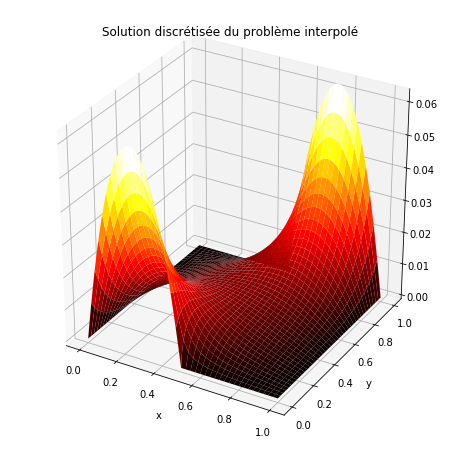

In [97]:
N = 200

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)

U = sol_disc_inter(N,-1,-1)

fig = plt.figure(figsize = [8,8])
ax = fig.add_subplot(111 ,projection='3d')
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y, U.reshape((N+1,N+1)), cmap='hot')
plt.title("Solution discrétisée du problème interpolé")
plt.xlabel("x")
plt.ylabel("y")

## Résolution de l'équation de la chaleur

Dans cette partie, on s'intéresse à la résolution de l'équation de la chaleur, c'est à dire à la discrétisation du problème suivant sur un domaine $\Omega = [0,1]\times[0,1]$ : 

$$
\left\{
    \begin{array}{ll}
        \dfrac{\partial u}{\partial t} = \Delta u &{sur }\quad \Omega \\
        u = 0 &\mbox{sur } \quad \partial u  
    \end{array}
\right.
$$

Pour faire cela, nous allons utiliser une méthode de discrétisation implicite. La stratégie sera la suivante : Nous allons tout d'abord réécrire la matrice de discrétisation du Laplacien seulement sur les points intérieurs du maillage que l'on notera $A$. Puis nous appliquerons la formule suivante : 

$$
\dfrac{U^{n+1} - U^n}{\delta t} = AU^{n+1}
$$

Ce qui va au final donné l'expression suivante : 

$$
U^{n+1} = (I - \delta t A)U^n
$$


On commence par importer tous les modules nécessaires : 

In [98]:
import numpy as np
import scipy.sparse as sparse   #Algèbre linéaire creuse
import matplotlib.pyplot as plt #Pour les graphiques
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import Axes3D

Puis on écrit la matrice de discrétisation du Laplacien, seulement sur les points intérieurs du maillage. On obtient, contrairement à la première partie du rapport, une matrice de taille $(N-1)(N-1)$. On va en plus ajouter un paramètre $\delta t$ à la matrice.

In [99]:
def matrix_lap(N,dt):
    """Retourne une matrice qui discrétise le laplacien de u dans le domaine Omega = [0,1]x[0,1], 
    découpé en N intervalles en x et y. La matrice finale est une matrice scipy.sparse CSR matrix. 
    Cette matrice est de taille (N-1)*(N-1)"""

    h = 1./N
    h2 = h*h

    #On note les inconnues de 1 à Nx-1 suivant x et 1 à Ny-1 suivant y. La taille du problème est donc (Nx-1)*(Ny-1).
    # Ici on prend Nx = Ny = N

    taille = (N-1)*(N-1)               #Taille de la matrice

    diags = np.zeros((5,taille))       # 5 diagonales à coder

    #Diagonale principale
    diags[2,:] = -(4*dt)/h2
              
    #Diagonale "-1"
    diags[1,:] = dt/h2
    
    #Diagonale "+1"
    diags[3,:] = dt/h2

    #Diagonale "-(N+1)"
    diags[0,:] = dt/h2

    #Diagonale "+(N+1)"
    diags[4,:] = dt/h2

    #Construction de la matrice creuse
    A = sparse.spdiags(diags,[-(N-1),-1,0,1,(N-1)],taille,taille, format = "csr")

    return A

Regardons ce que nous affiche la matrice $A$ pour $N = 4$ et un $\delta t = 0.1$

In [100]:
A = matrix_lap(4,0.1)
print(A.todense())

[[-6.4  1.6  0.   1.6  0.   0.   0.   0.   0. ]
 [ 1.6 -6.4  1.6  0.   1.6  0.   0.   0.   0. ]
 [ 0.   1.6 -6.4  1.6  0.   1.6  0.   0.   0. ]
 [ 1.6  0.   1.6 -6.4  1.6  0.   1.6  0.   0. ]
 [ 0.   1.6  0.   1.6 -6.4  1.6  0.   1.6  0. ]
 [ 0.   0.   1.6  0.   1.6 -6.4  1.6  0.   1.6]
 [ 0.   0.   0.   1.6  0.   1.6 -6.4  1.6  0. ]
 [ 0.   0.   0.   0.   1.6  0.   1.6 -6.4  1.6]
 [ 0.   0.   0.   0.   0.   1.6  0.   1.6 -6.4]]


Enfin, on écrit le code pour la discrétisation sur TOUS les points du maillage. En fait, on va créer un tableau des solutions en trois dimensions, il y aura dans ce tableau la valeur de la solution pour chaque temps $t$. Nous avons choisi de rédiger la solution de cette manière afin que l'utilisateur puisse afficher n'importer quelle valeur de la solution à un certain temps $t$ dans l'intervalle $[0,T]$.

In [101]:
def chaleur (N,dt,t):
    
    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)

    taille1 = (N-1)*(N-1)

    T = np.zeros((t,N+1,N+1))          #Initialisation de la solution finale, tableau 3 dimensions. On remarque 
                                       #que le tableau T est initialisé à 0 de taille TOUS les points du maillage pour
                                       #pour répondre aux conditions de bords.
            
    U = np.ones(taille1)               #Initialisation matrice pour discrétisation
    
    I = sparse.eye(taille1)            #Matrice de l'identité

    LAP = (I - matrix_lap(N,dt))       #La matrice à inverser

    for i in range(t):
        U = spsolve(LAP,U)
        T[i,1:N,1:N] = U.reshape(N-1,N-1).copy() #On copie la valeur du U dans le tableau pour avoir des 0 
                                                 #sur tous les bords et la valeur du Laplacien discrétisé dedans
    
    return T

        

Finalement on va procéder à l'affichage de la solution discrétisée. On se propose ici d'afficher la solution au temps $1$ et au temps $T$. Cependant l'utilisateur a juste à change la valeur du paramètre pour l'afficher au temps $t \in [0,T]$. On va afficher ici pour une valeur de $N = 100$, $\delta = 0.1$ et $T = 30$

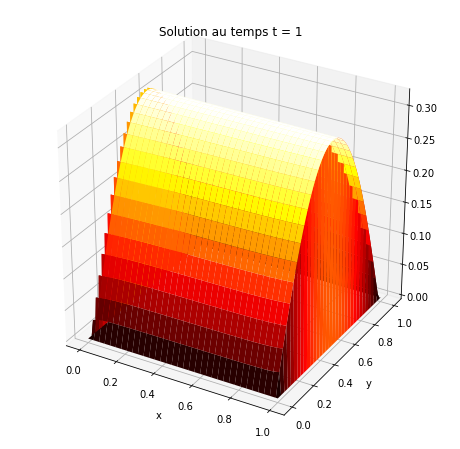

In [102]:
N = 100
dt = 0.1
t = 30

T = chaleur(N,dt,t)

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)

fig = plt.figure(figsize = [8,8])
    
ax = fig.add_subplot(111, projection = '3d')
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,T[1,:,:] ,cmap='hot')
plt.title("Solution au temps t = 1")
plt.xlabel("x")
plt.ylabel("y")

plt.show()

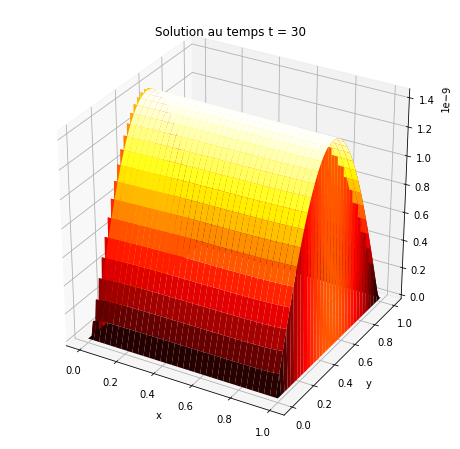

In [105]:
N = 100
dt = 0.1
t = 30

T = chaleur(N,dt,t)

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)

fig = plt.figure(figsize = [8,8])
    
ax = fig.add_subplot(111, projection = '3d')
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,T[t-1,:,:] ,cmap='hot')
plt.title("Solution au temps t = "+str(t))
plt.xlabel("x")
plt.ylabel("y")

plt.show()

On voit clairement grâce aux valeurs en $z$ que la courbe "s'applatit" et donc qu'il y a un lissage de la solution, ce qui correspond bien aux propriétés demandées par la résolution de l'équation de la chaleur